<a href="https://colab.research.google.com/github/AlekseyBuzmakov/2023-TextAI/blob/main/2023_TextAI_Word2vec_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

План:
- [X] Пример:
    - [X] Брать вектор
    - [X] most_similar
- [ ] Работа с предобученной моделью
    - [ ] Чистка данных
    - [ ] Базовое предсказание
- [ ] Обучение своей
    - [ ] Skip-grams (SG)
    - [ ] Continuous-bag-of-words (CBOW)


# Курс TextAI

# Материалы: https://bit.ly/2023-TextAI

# GitHUB: https://github.com/AlekseyBuzmakov/2023-TextAI

# Модель Word2Vec

Модель Word2Vec -- одна из языковых моделей, т.е. модель, которая содержит неявным образом информацию об определенных статистических зависимостях в тех или иных текстах.


## Что такое Ewbedding?

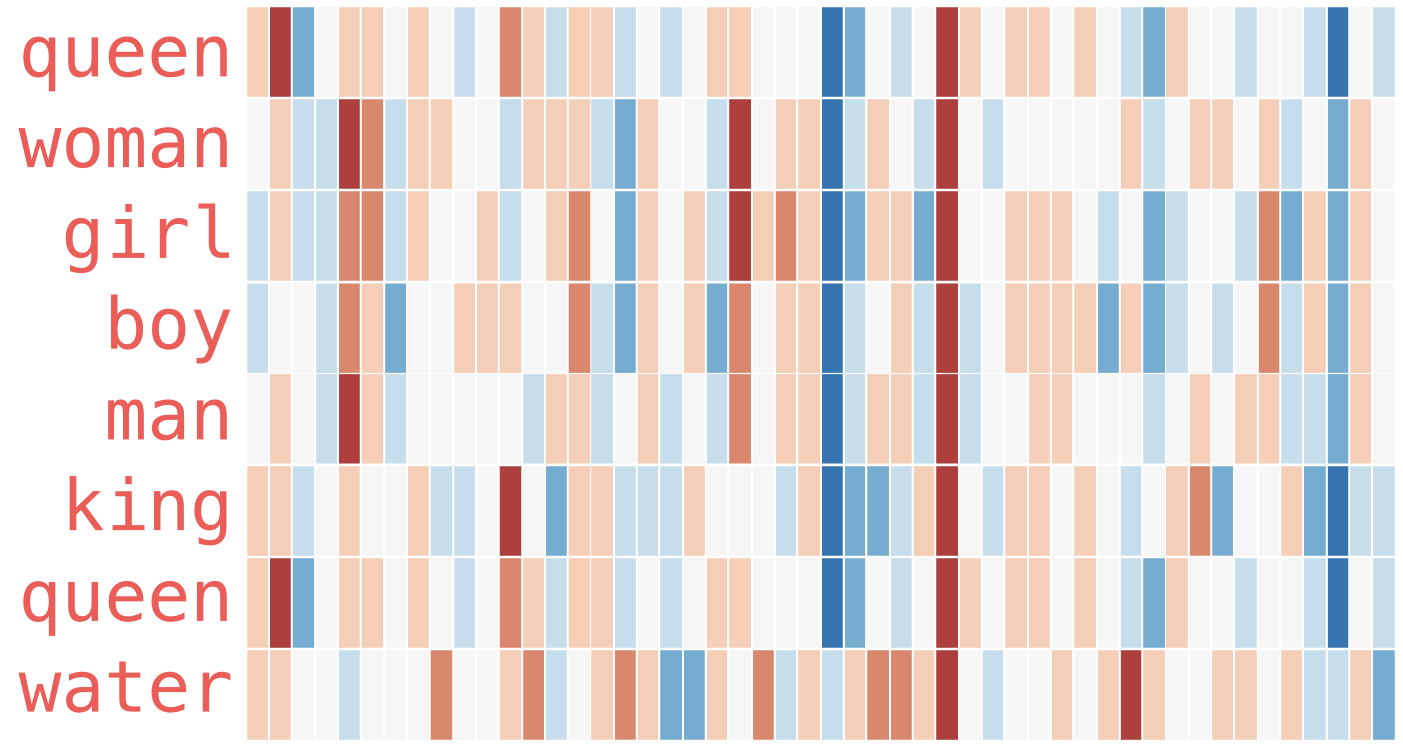

In [ ]:
# МЕНЯ ВСТАВИТЬ В САМОЕ НАЧАЛО ЛЮБОГО JupyterNotebook,
#   А ПРИ ПОВТОРНОЕ РАБОТЕ ВСЕГДА ЗАПУСКАТЬ!

# Тут имя папки, в которую все сохраняется. 
#  Менять это имя можно. 
#  На Google Drive должно быть та же папка
#  Регистр (ЗАГЛАВНЫЕ или строчные буквы) важен! 
FOLDER = "2023-TextAI" 

PATH = "drive/MyDrive/" + FOLDER  + "/"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PATH, exist_ok = True)

import sys
sys.path.append(PATH)

# Работа с данными



In [2]:
# Скачиваем данные
!gdown 1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o

Downloading...
From: https://drive.google.com/uc?id=1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o
To: /content/data.csv.zip
100% 83.9M/83.9M [00:00<00:00, 117MB/s]


In [ ]:
!cp data.csv.zip {PATH}

In [3]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
import gensim

from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

from collections import Counter

tqdm.pandas()
nltk.download("stopwords")
nltk.download('punkt')
random.seed(42)
np.random.seed(42)

<ipython-input-3-9875ed49926a>:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Загрузка данных

In [4]:
data = pd.read_csv("data.csv.zip", index_col="id")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data["date"] = pd.to_datetime(data["date"].str.replace(" PDT ", " "), format="%a %b %d %H:%M:%S %Y")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 1467810369 to 2193602129
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   emotion  1600000 non-null  int64         
 1   date     1600000 non-null  datetime64[ns]
 2   flag     1600000 non-null  object        
 3   user     1600000 non-null  object        
 4   text     1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 73.2+ MB


<Axes: xlabel='emotion', ylabel='count'>

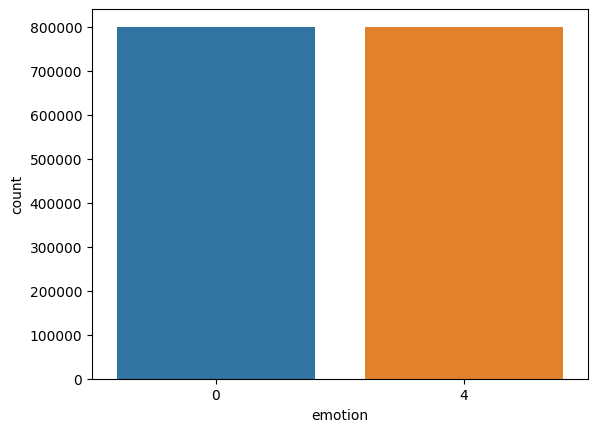

In [7]:
sns.countplot(data=data, x="emotion")

## Чистка текста

In [9]:
PUNCT_TO_REMOVE = string.punctuation + "«»№" # удаление знаков пунктуации
URL_PATTERN = r'https?://\S+|www\.\S+' # удаление ссылок
HTML_PATTERN = '<.*>'
USERNAME_PATTERN = "@\w+\s" # удаление имен пользователей
DIGIT_PATTERN = "\d+" # удаление цифр
regex_pattern = re.compile(f"({URL_PATTERN}|{HTML_PATTERN}|{USERNAME_PATTERN}|{DIGIT_PATTERN})")
stemmer = SnowballStemmer("english")
STOP_WORDS = nltk.corpus.stopwords.words('english') # самые распространенные слова
print(STOP_WORDS[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [10]:
example_text = data.iloc[0, -1] + " " + data.iloc[1000, -1]
example_text

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D @JonathanRKnight @silver_tulip27 Um, that would be a hell no to the fugly poker dog pants on the cruise!  Hi Jonathan, sorry I missed you "

In [11]:
text = regex_pattern.sub("", example_text)
text

" - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D Um, that would be a hell no to the fugly poker dog pants on the cruise!  Hi Jonathan, sorry I missed you "

In [12]:
text = nltk.tokenize.word_tokenize(text)
print(text)

['-', 'Awww', ',', 'that', "'s", 'a', 'bummer', '.', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';', 'D', 'Um', ',', 'that', 'would', 'be', 'a', 'hell', 'no', 'to', 'the', 'fugly', 'poker', 'dog', 'pants', 'on', 'the', 'cruise', '!', 'Hi', 'Jonathan', ',', 'sorry', 'I', 'missed', 'you']


In [15]:
normalized_text = [stemmer.stem(word) for word in text]
for normalized_word, original_word in zip(normalized_text, text):
    if normalized_word != original_word:
        print(f"{original_word=} {normalized_word=}")
text = normalized_text

original_word='Awww' normalized_word='awww'
original_word='You' normalized_word='you'
original_word='David' normalized_word='david'
original_word='Carr' normalized_word='carr'
original_word='Third' normalized_word='third'
original_word='Day' normalized_word='day'
original_word='D' normalized_word='d'
original_word='Um' normalized_word='um'
original_word='fugly' normalized_word='fug'
original_word='pants' normalized_word='pant'
original_word='cruise' normalized_word='cruis'
original_word='Hi' normalized_word='hi'
original_word='Jonathan' normalized_word='jonathan'
original_word='sorry' normalized_word='sorri'
original_word='I' normalized_word='i'
original_word='missed' normalized_word='miss'


In [45]:
cnt = Counter()

def clean_words(row, fast=True) -> str:
    if fast:
        text = regex_pattern.sub("", row["text"].lower()).split()
    else:
        text = regex_pattern.sub("", row["text"])
        text = nltk.tokenize.word_tokenize(text)
        text = [stemmer.stem(word) for word in text]
    text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
    text = [''.join(i for i in word if not i.isdigit()) for word in text]
    text = [word for word in text if word not in STOP_WORDS]

    for word in text:
        cnt[word] += 1
    return " ".join(text)

In [46]:
example_text, clean_words({"text": example_text}), clean_words({"text": example_text}, False)

("@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D @JonathanRKnight @silver_tulip27 Um, that would be a hell no to the fugly poker dog pants on the cruise!  Hi Jonathan, sorry I missed you ",
 '  awww  that s bummer  shoulda got david carr third day it   d um  would hell fugly poker dog pants cruise  hi jonathan  sorry missed',
 '  awww    s bummer   shoulda got david carr third day     um   would hell fug poker dog pant cruis   hi jonathan   sorri miss')

In [48]:
# data["text"] = data.progress_apply(clean_words, axis=1, fast=False)
data["text"] = data.progress_apply(clean_words, axis=1)

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [ ]:
data.to_csv(f'{PATH}/data_cleaned.csv.zip')

In [ ]:
data = pd.read_csv(f'{PATH}/data_cleaned.csv.zip')

In [36]:
is_null = data["text"].isnull()
is_null.sum()

0

In [37]:
data.loc[is_null,"text"] = ""

## Распространенные слова


In [38]:
cnt.most_common(10)

[('I', 496567),
 (' ', 182677),
 ('I m', 99823),
 ('get', 76832),
 ('like', 73306),
 ('go', 63017),
 ('good', 59775),
 ('day', 57142),
 ('got', 53995),
 ('going', 53241)]

In [39]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["text"])

CPU times: user 19.5 s, sys: 690 ms, total: 20.2 s
Wall time: 20.4 s


In [40]:
X.shape

(1600000, 286794)

In [41]:
X = pd.Series(sorted(np.squeeze(np.asarray((X != 0).sum(axis=0)))))
X[-10:]

286784     62344
286785     62788
286786     66834
286787     70922
286788     75464
286789     79183
286790     81066
286791     84341
286792     87517
286793    122780
dtype: int64

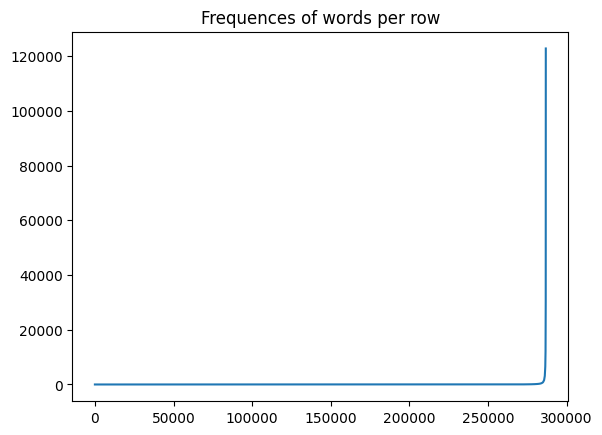

In [42]:
plt.plot(X)
plt.title("Frequences of words per row");

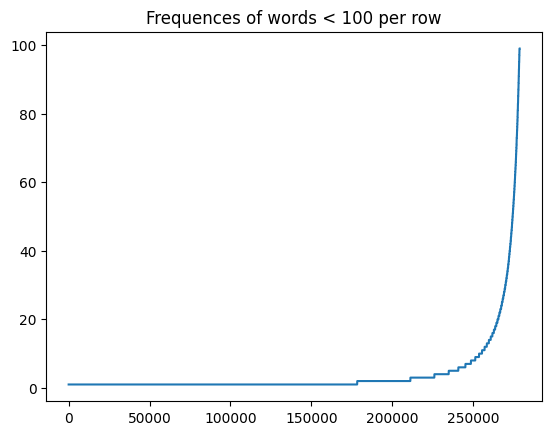

In [43]:
plt.plot(X[X<100])
plt.title("Frequences of words < 100 per row");

# Word2Vec


## Примеры Word2Vec

In [ ]:
%%time
from gensim import downloader

#wv = downloader.load('word2vec-google-news-300') # Очень большая
wv = downloader.load('glove-twitter-25') # Не совсем Word2Vec, но для демонстрации хватит

[==================================================] 100.0% 104.8/104.8MB downloaded
CPU times: user 59.8 s, sys: 2.67 s, total: 1min 2s
Wall time: 1min 23s


In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


![](https://raw.githubusercontent.com/amanjeetsahu/Natural-Language-Processing-Specialization/d562105e68a0b85012ad3ebbb29b2af6344ad4e5/Natural%20Language%20Processing%20with%20Classification%20and%20Vector%20Spaces/Week%203/vectors.jpg)

$$cos(X,Y) = \frac{<X, Y>}{||X||*||Y||}$$

Поиск ближайших соседей из примера с помощью gensim

In [ ]:
wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity for W2V

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949)]

Рассчет схожести известных слов с помощью sklearn



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
computed_vector = [wv["king"]-wv["man"]+wv["woman"]]
intresting_words = ["queen", "prince", "princess"]
for word, result in zip(intresting_words, cosine_similarity(computed_vector, wv[intresting_words])[0]):
    print(f"Result for {word=} is {result=}")

Result for word='queen' is result=0.7530913
Result for word='prince' is result=0.7605474
Result for word='princess' is result=0.6824288


Рассчет схожести известных слов на numpy

In [ ]:
(computed_vector @ wv["queen"]) / (np.linalg.norm(computed_vector) * np.linalg.norm(wv["queen"]))

array([0.7530913], dtype=float32)

Тренируемся на котятах и щенках
![](https://petstory.ru/resize/800x800x80/upload/images/articles//kotyenok-i-shchenok-v-odnoy-kvartire/kitt-and-pupp1.jpg)

In [ ]:
# Для примера

## Применение Word2Vec

Тк будут классифицироваться твиты, то надо получать эмбединг самого твита. В данном случае будут усредняться все слова для которых известен вектор.

In [ ]:
emb_line = np.mean([wv.get_vector(w) for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(25,)
[ 0.01275918  0.3783      0.26857814 -0.09810553 -0.28757185 -0.14726429
  0.7814658   0.22118823 -0.21822335 -0.40642798 -0.23787588  0.05436118
 -4.2523656  -0.07335228  0.23735543 -0.20234807  0.16559085 -0.1915705
 -0.21897423 -0.1164306   0.04481166  0.2739632   0.26046303  0.22364709
 -0.16728576]


In [ ]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

emb_line = np.mean([(wv.get_vector(w) - mean) / std for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(25,)
[ 0.5418681   0.0666009   0.25358456 -0.14372444 -0.1527933   0.24198481
  1.3964447   1.3237357  -0.57213163  0.02572083  0.02322836 -0.25143954
 -5.2126303  -0.05285202  0.04484933 -0.6432597  -0.12959705 -0.3371484
 -1.0387126  -0.4231328  -0.05462204  0.06145263  0.21464571  0.27547774
  0.16824484]


In [ ]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(wv.get_vector(w) - mean) / std for w in row["text"] if w in wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [ ]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [ ]:
data = None
wv = None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 25), (1280000,), (320000, 25), (320000,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 30.3 s, sys: 10.9 s, total: 41.2 s
Wall time: 24.9 s


In [ ]:
f"{f1_score(predicted, y_test.values, pos_label=0)=}, {accuracy_score(predicted, y_test.values)=}"

'f1_score(predicted, y_test.values, pos_label=0)=0.5685133440747256, accuracy_score(predicted, y_test.values)=0.562309375'

In [ ]:
clf = None
X = None
X_train = None
X_test = None
y_train = None
y_test = None
vectorizer = None
y = None
predicted = None

## Обучение Word2Vec

In [ ]:
import gensim.models

In [ ]:
data = pd.read_csv(f'{PATH}/data_cleaned.csv.zip')

In [ ]:
is_null = data["text"].isnull()
is_null.sum()

2823

In [ ]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, sentences: list[str]):
        self.sentences = sentences

    def __iter__(self):
        for line in self.sentences:
            # assume there's one document per line, tokens separated by whitespace
            yield line.split()

In [ ]:
corpus = MyCorpus(data["text"].values)

In [ ]:
%%time
model = gensim.models.Word2Vec(sentences=corpus, vector_size=25, sg=0) # sg=0 -- CBOW, sg=1 -- SKIP GRAMM

CPU times: user 5min 47s, sys: 1.61 s, total: 5min 49s
Wall time: 3min 56s


In [ ]:
model.wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity

[('animal', 0.7354238629341125),
 ('bond', 0.7201212644577026),
 ('pole', 0.7117068767547607),
 ('sex', 0.6986674070358276),
 ('scene', 0.6916687488555908)]

In [ ]:
mean = np.mean(model.wv.vectors, 0)
std = np.std(model.wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(model.wv.get_vector(w) - mean) / std for w in row["text"] if w in model.wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, model.wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [ ]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 25), (1280000,), (320000, 25), (320000,))

In [ ]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [ ]:
f1_score(predicted, y_test.values, pos_label=0), accuracy_score(predicted, y_test.values)

(0.5771304621110817, 0.5711125)

In [ ]:
print()